Determine the exceedance probability of water level of each site in each month.

In [28]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

plt.style.use(['seaborn-colorblind', 'seaborn-talk'])
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta'] # to plot Chinese words properly

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

# Merge data
Calculate the absolute water elevation (WRA data) back to relative water level. I can't do that in the opposite way on the EPA data because I don't have the elevation of site. If later the elvation of water level is needed, I can transform them back.

In [2]:
wra_df = pd.read_hdf('data/database_ZAF_clean_gps_20211008.hd5', key='wl')
wra_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38292359 entries, 0 to 38292358
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   井名      object 
 1   井號      object 
 2   日期時間    object 
 3   Lon     float64
 4   Lat     float64
 5   SiteEl  float64
 6   水位(m)   float64
dtypes: float64(4), object(3)
memory usage: 2.3+ GB


In [10]:
epa_df = pd.read_csv('data/database_ZAF_wl+wa_epa_clean_gps_20211008.csv',
    usecols=['SiteName', 'Datetime', 'SiteId', 'WaterDe_m', 'Lon', 'Lat'])
epa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2599 entries, 0 to 2598
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SiteName   2599 non-null   object 
 1   Datetime   2599 non-null   object 
 2   SiteId     2599 non-null   int64  
 3   WaterDe_m  1672 non-null   float64
 4   Lon        2599 non-null   float64
 5   Lat        2599 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 122.0+ KB


In [7]:
wra_df = wra_df.drop('WaterDe_m', axis=1)
wra_df['水面至井口深度'] = wra_df.SiteEl - wra_df['水位(m)']

In [12]:
epa_df.columns = ['井名', '日期時間', '井號', '水面至井口深度', 'Lon', 'Lat']

In [14]:
merge_df = pd.concat(
    [epa_df,
     wra_df.loc[:, ['井名', '日期時間', '井號', '水面至井口深度', 'Lon', 'Lat']]],
     join='outer', axis=0
)
merge_df

,井名,日期時間,井號,水面至井口深度,Lon,Lat
0,二崙國小,2000-03-22 00:00:00,4413,NaN,120.415102,23.771842
1,二崙國小,2000-06-21 00:00:00,4413,NaN,120.415102,23.771842
2,二崙國小,2000-08-17 00:00:00,4413,NaN,120.415102,23.771842
3,二崙國小,2000-12-20 00:00:00,4413,NaN,120.415102,23.771842
4,二崙國小,2002-03-14 11:51:00,4413,NaN,120.415102,23.771842
...,...,...,...,...,...,...
38292354,東石(4),2021-09-21 23:10:00,10090141,17.349,120.154469,23.460335
38292355,東石(4),2021-09-21 23:20:00,10090141,17.345,120.154469,23.460335
38292356,東石(4),2021-09-21 23:30:00,10090141,17.342,120.154469,23.460335
38292357,東石(4),2021-09-21 23:40:00,10090141,17.341,120.154469,23.460335


In [15]:
len(merge_df) - len(epa_df) - len(wra_df)

0

In [37]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36815359 entries, 16 to 38292358
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   井名       object 
 1   日期時間     object 
 2   井號       object 
 3   水面至井口深度  float64
 4   Lon      float64
 5   Lat      float64
 6   月        int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 2.2+ GB


In [18]:
merge_df['水面至井口深度'].isna().sum()/len(merge_df)

0.0386369140292568

In [19]:
# exclude NAN
merge_df = merge_df[~merge_df['水面至井口深度'].isna()].copy()

In [28]:
# generate month column for later use
merge_df['月'] = [int(_.split('-')[1]) for _ in merge_df['日期時間']]

In [30]:
merge_df.to_hdf('data/database_ZAF_clean_gps_{}.hd5'.format(date), key='wl', mode='w', encoding='utf-8')

C:\Users\An-Sheng\Miniconda3\envs\ncdr\lib\site-packages\pandas\core\generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['井名', '日期時間', '井號'], dtype='object')]

  pytables.to_hdf(


# Calculate the probability 
in each site by month

In [5]:
merge_df = pd.read_hdf('data/database_ZAF_clean_gps_20211104.hd5', key='wl')

In [10]:
print(merge_df['日期時間'].min(), merge_df['日期時間'].max())

2005-02-15 12:59:00 2021-09-21 23:50:00


In [20]:
sample = merge_df.loc[(merge_df['井號'] == 10090141) & (merge_df['月'] == 9), '水面至井口深度'].values
sample_mean = np.mean(sample)
sample_std = np.std(sample)
dist = stats.norm(loc=sample_mean, scale=sample_std)
prob = [_*.01 for _ in range(0, 101)]
values = [dist.ppf(_) for _ in prob]

No handles with labels found to put in legend.


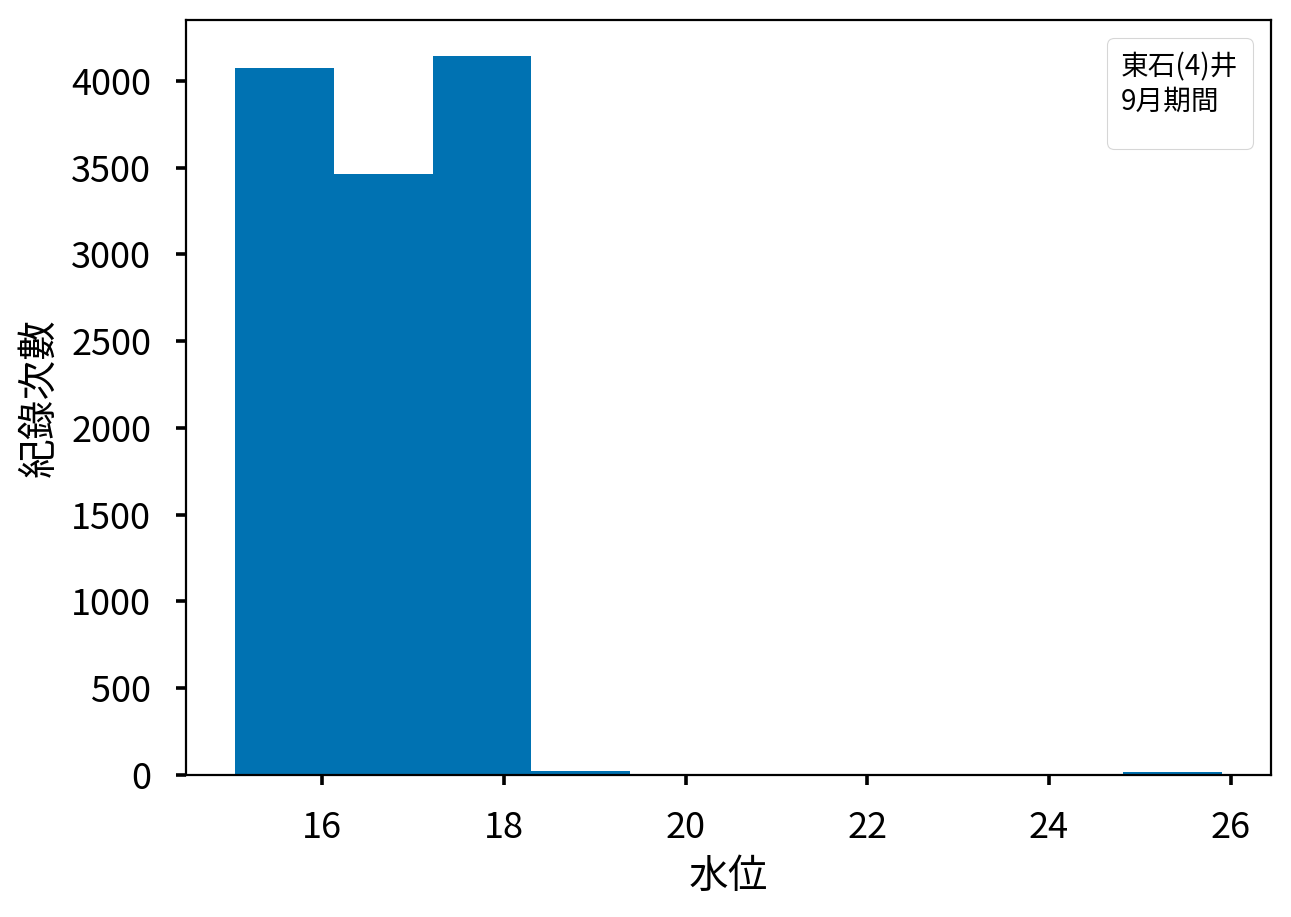

In [40]:
plt.figure(figsize=(7, 5))
plt.hist(sample)
plt.ylabel('紀錄次數')
plt.xlabel('水位')
plt.legend(title='東石(4)井\n9月期間')
plt.savefig('results/東石4_9月_水位分佈.png')

No handles with labels found to put in legend.


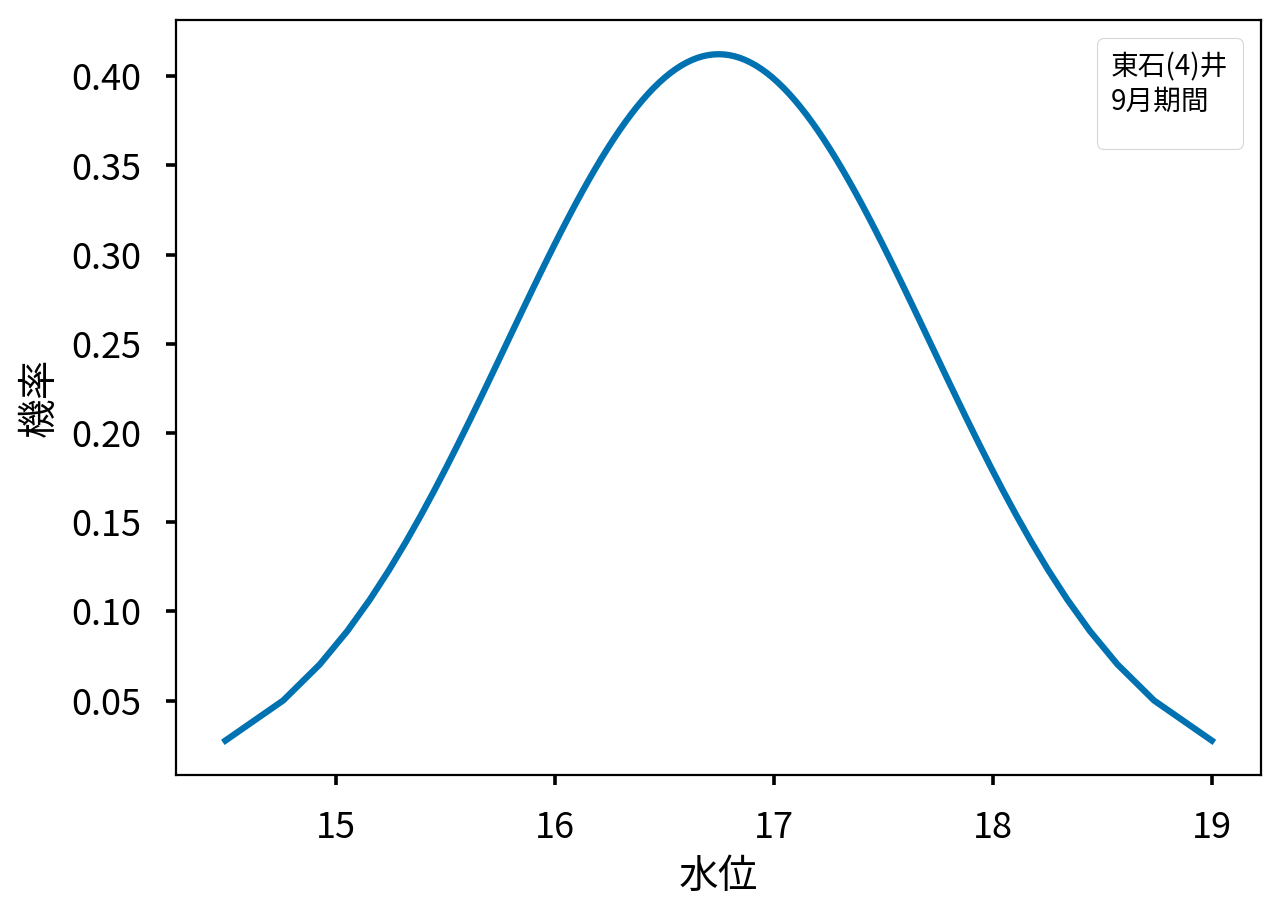

In [41]:
plt.figure(figsize=(7, 5))
plt.plot(values, dist.pdf(values))
plt.ylabel('機率')
plt.xlabel('水位')
plt.legend(title='東石(4)井\n9月期間')
plt.savefig('results/東石4_9月_水位機率分佈.png')

No handles with labels found to put in legend.


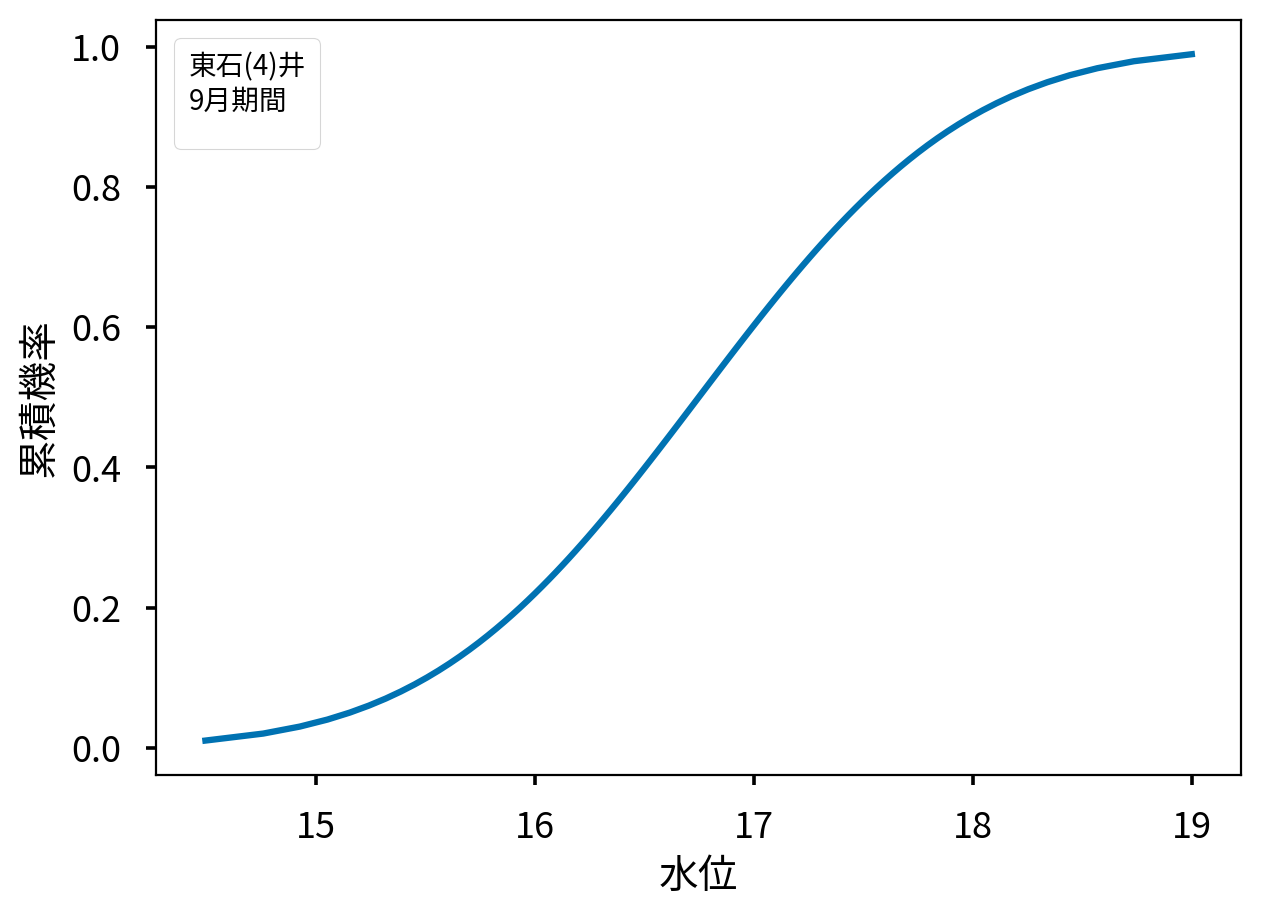

In [42]:
plt.figure(figsize=(7, 5))
plt.plot(values, prob)
plt.ylabel('累積機率')
plt.xlabel('水位')
plt.legend(title='東石(4)井\n9月期間')
plt.savefig('results/東石4_9月_水位累積機率分佈.png')

## Single thread

In [31]:
probs = [10, 20, 25, 35, 75, 85]
siteids = []
sitenames = []
mons = []
levels = []
info_df = pd.DataFrame()
for siteid in merge_df['井號'].unique()[:2]:
    for mon in range(1, 13):
        X = merge_df[(merge_df['井號'] == siteid) & (merge_df['月'] == mon)].copy()
        # only caculate when data amount is more than 4
        # to exclude the doubious excedance probability
        if len(X) > 4:
            #print(siteid, mon)
            #print(np.mean(X['水面至井口深度']), np.std(X['水面至井口深度']))
            dist = stats.norm(loc=np.mean(X['水面至井口深度']), scale=np.std(X['水面至井口深度']))
            info_df = info_df.append(X.iloc[0, [0,2,4,5,6]])
            #siteids.append(siteid)
            #sitenames.append(X['井名'].values[0])
            #mons.append(mon)
            levels.append([dist.ppf(prob*.01) for prob in probs])

In [ ]:
level_df = pd.DataFrame(levels, columns=probs)
compile_df = pd.concat([info_df.reset_index(drop=True), level_df], axis=1, join='inner')

In [ ]:
compile_df

,井名,井號,Lon,Lat,月,10,20,25,35,75,85
0,二崙國小,4413.0,120.415102,23.771842,1.0,4.036129,4.243898,4.322830,4.459397,4.959920,5.130857
1,二崙國小,4413.0,120.415102,23.771842,4.0,4.310834,4.513082,4.589917,4.722857,5.210083,5.376479
2,二崙國小,4413.0,120.415102,23.771842,5.0,3.773519,4.037704,4.138069,4.311720,4.948153,5.165506
3,二崙國小,4413.0,120.415102,23.771842,8.0,2.926410,3.166050,3.257090,3.414607,3.991910,4.189069
4,二崙國小,4413.0,120.415102,23.771842,10.0,3.264489,3.592239,3.716753,3.932185,4.721747,4.991397
5,口湖國小青蚶分校,4403.0,120.161008,23.597331,1.0,1.466430,1.520486,1.541023,1.576554,1.706777,1.751251
6,口湖國小青蚶分校,4403.0,120.161008,23.597331,4.0,1.463488,1.548740,1.581128,1.637164,1.842539,1.912678
7,口湖國小青蚶分校,4403.0,120.161008,23.597331,5.0,1.510024,1.572021,1.595573,1.636324,1.785677,1.836683
8,口湖國小青蚶分校,4403.0,120.161008,23.597331,8.0,1.319115,1.390374,1.417446,1.464286,1.635954,1.694581
9,口湖國小青蚶分校,4403.0,120.161008,23.597331,10.0,1.429806,1.489894,1.512721,1.552217,1.696971,1.746407


## Multi-thread 1
It takes too long to slice data (X) in single thread before the works are submitted to the muliti-processing.

In [15]:
from dask import delayed
from dask.distributed import Client
client = Client(memory_limit='25GB')

In [60]:
def get_cdf(X, probs):
    # get the water levels of the selected probabilities
    dist = stats.norm(loc=np.mean(X['水面至井口深度']), scale=np.std(X['水面至井口深度']))
    return [dist.ppf(prob*.01) for prob in probs]

def get_info(X):
    # get '井名', '井號', 'Lon', 'Lat', '月'
    return X.iloc[0, [0,2,4,5,6]]

def compile_list(levels, probs):
    return pd.DataFrame(levels, columns=probs)

def append_df(info_dfs):
    return pd.concat(info_dfs, axis=1, join='outer').T.reset_index(drop=True)

def compile_df(listanddf):
    return pd.concat(listanddf, axis=1, join='outer')



probs = [10, 20, 25, 35, 75, 85]
levels = []
info_dfs = []
for siteid in merge_df['井號'].unique():
    for mon in range(1, 13):
        X = merge_df[(merge_df['井號'] == siteid) & (merge_df['月'] == mon)].copy()
        # only caculate when data amount is more than 4
        # to exclude the doubious excedance probability
        if len(X) > 4:
            levels.append(delayed(get_cdf)(X, probs))
            info_dfs.append(delayed(get_info)(X))

total = delayed(compile_df)([delayed(compile_list)(levels, probs), 
                           delayed(append_df)(info_dfs)])

KeyboardInterrupt: 

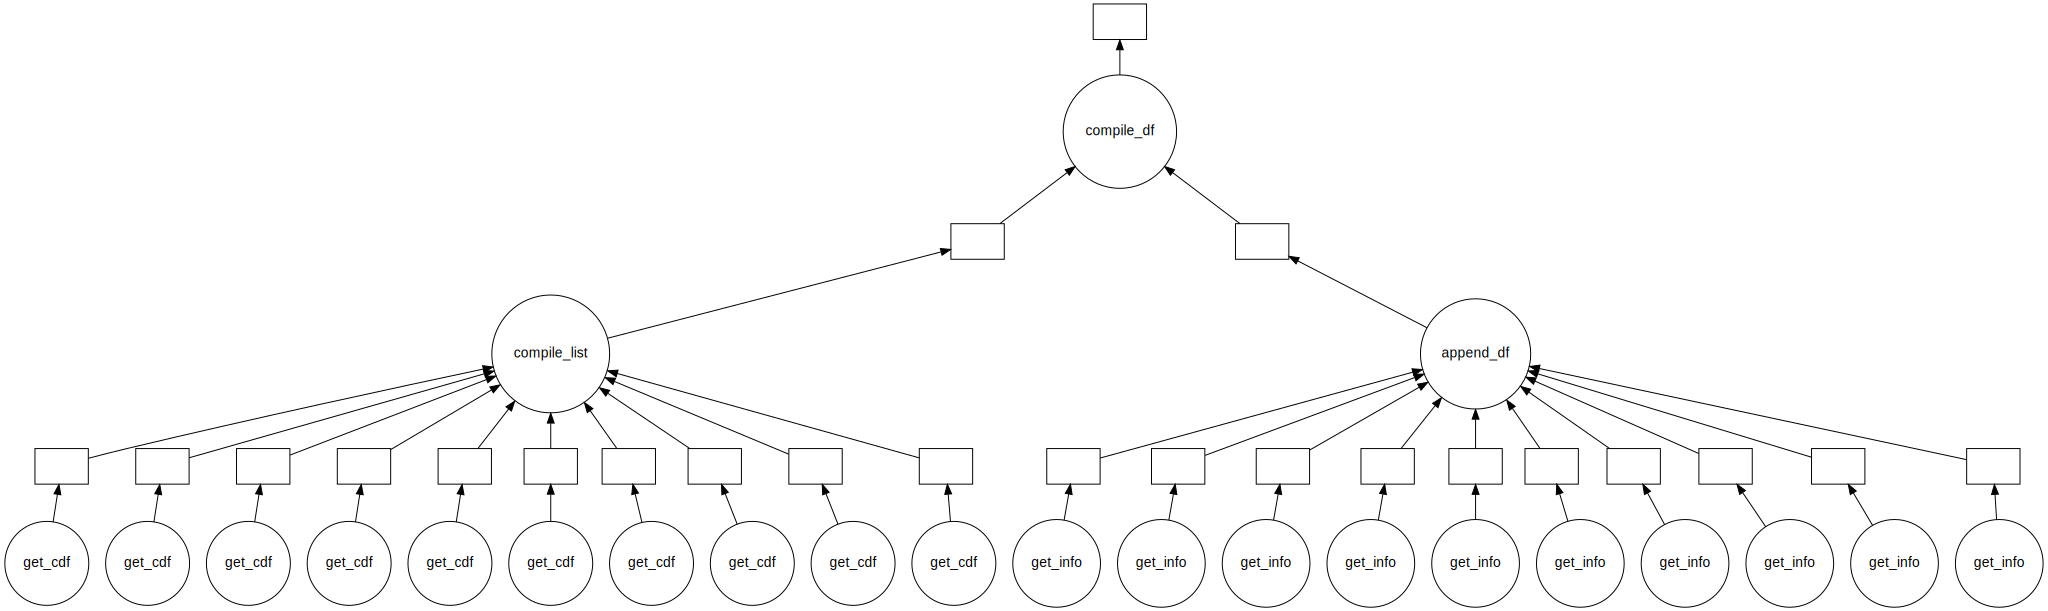

In [51]:
total.visualize('results/add_gps.svg')

In [58]:
%%time
lvl_df = total.compute()

Wall time: 883 ms


In [59]:
lvl_df

,10,20,25,35,75,85,井名,井號,Lon,Lat,月
0,4.036129,4.243898,4.322830,4.459397,4.959920,5.130857,二崙國小,4413,120.415102,23.771842,1
1,4.310834,4.513082,4.589917,4.722857,5.210083,5.376479,二崙國小,4413,120.415102,23.771842,4
2,3.773519,4.037704,4.138069,4.311720,4.948153,5.165506,二崙國小,4413,120.415102,23.771842,5
3,2.926410,3.166050,3.257090,3.414607,3.991910,4.189069,二崙國小,4413,120.415102,23.771842,8
4,3.264489,3.592239,3.716753,3.932185,4.721747,4.991397,二崙國小,4413,120.415102,23.771842,10
5,1.466430,1.520486,1.541023,1.576554,1.706777,1.751251,口湖國小青蚶分校,4403,120.161008,23.597331,1
6,1.463488,1.548740,1.581128,1.637164,1.842539,1.912678,口湖國小青蚶分校,4403,120.161008,23.597331,4
7,1.510024,1.572021,1.595573,1.636324,1.785677,1.836683,口湖國小青蚶分校,4403,120.161008,23.597331,5
8,1.319115,1.390374,1.417446,1.464286,1.635954,1.694581,口湖國小青蚶分校,4403,120.161008,23.597331,8
9,1.429806,1.489894,1.512721,1.552217,1.696971,1.746407,口湖國小青蚶分校,4403,120.161008,23.597331,10


## Multi-thread 2
Include slicing data (X) to the multi-threads, whcih enpwoers the multi-processing

In [33]:
def get_cdf(merge_df, siteid, mon, probs):
    X = merge_df[(merge_df['井號'] == siteid) & (merge_df['月'] == mon)].copy()
    # only caculate when data amount is more than 4
    # to exclude the doubious excedance probability
    if len(X) > 4:
    # get the water levels of the selected probabilities
        dist = stats.norm(loc=np.mean(X['水面至井口深度']), scale=np.std(X['水面至井口深度']))
        levels = [round(dist.ppf(prob*.01), 2) for prob in probs]
        # '井名', '井號', 'Lon', 'Lat', '月', 'levels'
        out = np.hstack([X.iloc[0, 0], X.iloc[0, 2], X.iloc[0, 4], 
                         X.iloc[0, 5], X.iloc[0, 6], levels])
    else:
        out = [None for _ in range(5+len(probs))]
    return out


def build_df(out_list, probs):
    return pd.DataFrame(out_list, columns=np.hstack(['井名', '井號', 'Lon', 'Lat', '月', probs]))

df_future = client.scatter(merge_df)
probs = [10, 20, 25, 35, 75, 85]
out_list = []

for siteid in merge_df['井號'].unique():
    for mon in range(1, 13):
        out_list.append(delayed(get_cdf)(df_future, siteid, mon, probs))
total = delayed(build_df)(out_list, probs)

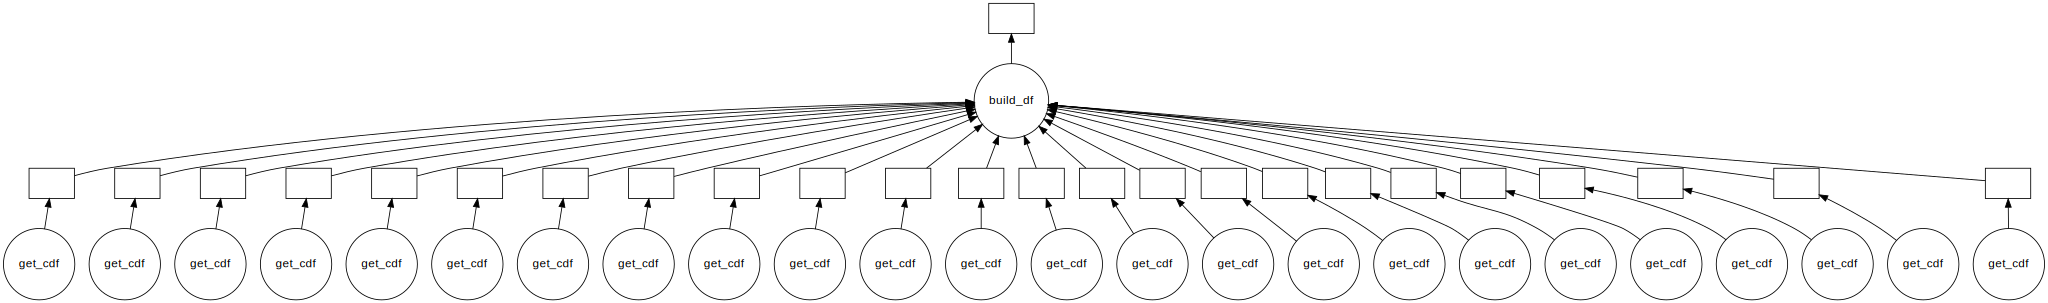

In [5]:
total.visualize('results/build_prob.svg')

In [34]:
%%time
lvl_df = total.compute()

Wall time: 57min 43s


In [35]:
clean_df = lvl_df[~lvl_df.Lon.isna()].copy()

In [36]:
print(lvl_df.shape)
print(clean_df.shape)

(4896, 11)
(4492, 11)


In [37]:
clean_df.to_csv('data/wl_EP_{}.csv'.format(date), index=False)